In [ ]:
### temas a consultar
"""

Modelo KMV (Kecholfer, McQuown y Vasicek)
Probit y Logit
survival analysis
PCA Curves
Score de credito
CDS, ABS, MBS, CDO

"""

## 1. Modelación de Curva Yield con PCA para Valoración de Riesgo de Mercado


Esta sección veremos cómo los componentes principales calculados en una serie temporal multivariada de curvas de rendimiento para EE.UU. permiten identificar el tipo los tipos de movimientos más comunes  que ocurren en las tasas de interés a diferentes vencimientos. El paper seminal de esta sección es **Litterman, R., & Scheinkman, J. (1991). Common factors affecting bond returns. Journal of fixed income**

### 1.1 Teoría: Curva Yield

In [2]:
import pandas as pd
import numpy as np
import fredapi
import plotly.express as px

#pip install fredapi
#pip install fred

# load yield curve data for the 10-year Treasury constant maturity rate from FRED
fred = fredapi.Fred(api_key='')
yield_curve_3m = fred.get_series('DTB3', start_date='2010-01-01').dropna()
yield_curve_1y = fred.get_series('DGS1', start_date='2010-01-01').dropna()
yield_curve_2y = fred.get_series('DGS2', start_date='2010-01-01').dropna()
yield_curve_5y = fred.get_series('DGS5', start_date='2010-01-01').dropna()
yield_curve_10y = fred.get_series('DGS10', start_date='2010-01-01').dropna()
yield_curve_20y = fred.get_series('DGS20', start_date='2010-01-01').dropna()
yield_curve = pd.DataFrame({'3m': yield_curve_3m,
                            '1y': yield_curve_1y,
                            '2y': yield_curve_2y,
                            '5y': yield_curve_5y,
                            '10y': yield_curve_10y,
                            '20y': yield_curve_20y}).loc["2000-01-01":].dropna()





In [20]:
# Veamos la curva en diferentes cortes de tiempo
yield_curve_2010=yield_curve.loc["2010-12-15"]
yield_curve_2020=yield_curve.loc["2020-03-30"]
yield_curve_2023=yield_curve.loc["2023-01-30"]
yield_cross=pd.concat([yield_curve_2010,yield_curve_2020,yield_curve_2023],axis=1)
yield_cross.columns=["2010","2020","2023"]
fig = px.line(yield_cross,title='Yield Curves in Time',markers=True)
fig.show()

In [21]:
# Veamos el comportamiento Historico de cada nodo
fig = px.line(yield_curve,title='Yield Nodes in Time')
fig.show()

Para el propósito del análisis actual, no será relevante tanto la forma particular que asuma la curva de rendimiento en un determinado día, sino que nos enfocaremos los cambios absolutos entre dos puntos consecutivos en el tiempo. Estos movimientos en la curva resulta útiles no  solo para el análisis del riesgo de interés, sino también para determinar el allocation en un portafolio que podrían aprovechar dichos movimientos.

In [22]:
#Veamos la correlación de la estructura a plazos de la tasa de interés
yield_curve.corr()

,3m,1y,2y,5y,10y,20y
3m,1.000000,0.991097,0.970685,0.887318,0.758276,0.646582
1y,0.991097,1.000000,0.990328,0.916129,0.786726,0.673810
2y,0.970685,0.990328,1.000000,0.956499,0.843203,0.737759
5y,0.887318,0.916129,0.956499,1.000000,0.957226,0.888586
10y,0.758276,0.786726,0.843203,0.957226,1.000000,0.980877
20y,0.646582,0.673810,0.737759,0.888586,0.980877,1.000000


Observamos que la estructura  está altamente correlacionada, en particular, entre tasas de vencimiento cercano. Las cifras en la tabla muestran   que la correlación entre los rendimientos es mayor alrededor de la diagonal principal, lo que significa que las tasas de interés de maturity similar se mueven de manera cercana. Por el contrario, la correlación es más débil entre las tasas de interés de vencimientos mas lejanos.

In [26]:
#Veamos la correlación de la estructura a plazos de la tasa de interés
fig=px.imshow(yield_curve.corr(), text_auto=True, aspect="auto",color_continuous_scale='RdBu_r')
fig.show()

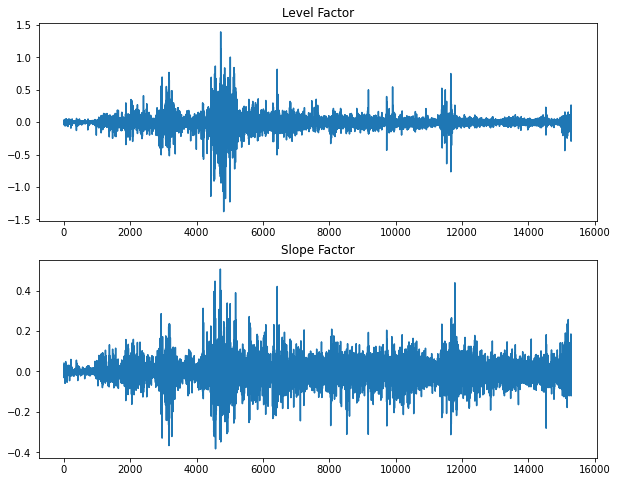

In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# load yield curve data for the 10-year Treasury constant maturity rate from FRED
fred = fredapi.Fred(api_key='2f37a721ab039829f23625cd2e71b902')
yield_curve_10y = fred.get_series('DGS10', start_date='2010-01-01').dropna()
yield_curve_3m = fred.get_series('DTB3', start_date='2010-01-01').dropna()
#DGS2, DGS1, DGS5,DGS3,DGS20
#

# combine yield curves into a single DataFrame
yield_curve = pd.DataFrame({'10y': yield_curve_10y, '3m': yield_curve_3m})
# calculate changes in yield rates for each maturity
changes = yield_curve.diff().dropna()
changes=changes.values
# use PCA to extract level and slope factors
pca = PCA(n_components=2)
factors = pca.fit_transform(changes)

# plot time series of slope and level factors
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax[0].plot(factors[:, 0])
ax[0].set_title('Level Factor')
ax[1].plot(factors[:, 1])
ax[1].set_title('Slope Factor')
plt.show()


In [18]:
changes

array([-0.00738916, -0.00992556,  0.0075188 , ...,  0.03458213,
       -0.03064067, -0.02873563])

In [14]:
yield_curve.dropna().isnull().sum()

0

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# example yield curve data for multiple nodes (10 nodes, 8 maturities each)
yield_curves = pd.DataFrame(np.random.randn(8, 10), columns=list('ABCDEFGHIJ'))

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


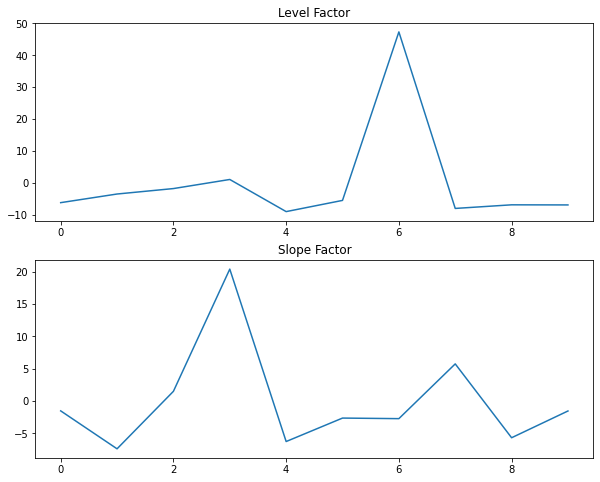

In [4]:
# calculate changes in yield rates for each maturity and node
yields = yield_curves.values
changes = np.diff(yields, axis=0) / yields[:-1, :]

# use PCA to extract level and slope factors
pca = PCA(n_components=2)
factors = pca.fit_transform(changes.T)

# plot time series of slope and level factors
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax[0].plot(factors[:, 0])
ax[0].set_title('Level Factor')
ax[1].plot(factors[:, 1])
ax[1].set_title('Slope Factor')
plt.show()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Leemos la data de la ruta o repositorio
df = pd.read_csv("spot_curve_uk.csv")
# Select all of the data up to 10 years

df.set_index("Date",inplace=True)
df.head()

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,...,20.5,21.0,21.5,22.0,22.5,23.0,23.5,24.0,24.5,25.0
Date,,,,,,,,,,,,,,,,,,,,,
31/01/2000,6.32,6.43,6.47,6.48,6.46,6.43,6.39,6.34,6.29,6.23,...,4.45,4.42,4.40,4.38,4.36,4.34,4.32,4.31,4.30,4.29
29/02/2000,6.25,6.30,6.30,6.28,6.24,6.19,6.13,6.07,6.01,5.95,...,4.34,4.31,4.29,4.27,4.26,4.24,4.23,4.21,4.20,4.19
31/03/2000,6.25,6.29,6.27,6.22,6.16,6.09,6.01,5.93,5.86,5.78,...,4.33,4.31,4.29,4.28,4.27,4.25,4.24,4.23,4.22,4.21
30/04/2000,6.10,6.10,6.07,6.02,5.96,5.90,5.83,5.77,5.70,5.64,...,4.24,4.22,4.21,4.19,4.18,4.16,4.15,4.14,4.13,4.12
31/05/2000,6.13,6.16,6.14,6.08,6.01,5.93,5.85,5.77,5.70,5.62,...,4.28,4.26,4.24,4.22,4.20,4.18,4.16,4.15,4.13,4.11


### Probit

Cuyo nombre proviene de la abreviación de **probability unit**

Pasaremos a modelar ahora situaciones donde buscamos un indicador o conocer si un resultado se ha dado. Modelaremos entonces probabilidades usando herramientas econometricas para hacer proposiciones probabilisticas acerca de la ocurrencia de estos eventos. 

Así estos modelos a estudiar son inherentemente e intrinsecamente no lineales. Empezaremos así con resultados binarios 

### Models for binary outcomes

Construiremos modelos que relacionan un resultado a un conjunto de factores. Nuestra aproximación buscará analizar cada uno de ellos en el marco general de un modelo de probabilidad:

Prob(event j occurs | **x**) = Prob(Y = j | **x**) = F(relevant effects, parameters, **x**)

Prob(Y = 1| **x**) = Probability that event of interest occurs| **x**,

y, naturalmente, Prob(Y = 0| x) = [1 - Prob(Y = 1| x)] es la probabilidad de que el evento no ocurra. 

$Prob(Y = 1| x) =\int_{-\infty }^{x'B}\phi(t)\mathrm{d} t=\Phi(x'B)$

The question of which distribution to use is a natural one. The logistic distribution
is similar to the normal except in the tails, which are considerably heavier. (It more
closely resembles a t distribution with seven degrees of freedom.) For intermediate
values of xB, the two distributions tend to give very similar probabilities. The
logistic distribution tends to give larger probabilities to Y = 1 when xB is extremely
small (and smaller probabilities to Y = 1 when xB is very large) than the normal
distribution. It is difficult to provide practical generalities on this basis, however,
as they would require knowledge of B. We might expect different predictions from
the two models, however, if the sample contains (1) very few responses (Y’s equal
to 1) or very few nonresponses (Y’s equal to 0) and (2) very wide variation in an
important independent variable, particularly if (1) is also true. There are practical
reasons for favoring one or the other in some cases for mathematical convenience, but
it is difficult to justify the choice of one distribution or another on theoretical grounds.
Amemiya (1981) discusses a number of related issues, but as a general proposition,
the question is unresolved. In most applications, the choice between these two seems
not to make much difference.

In [8]:
import pandas as pd
import numpy as np
import statsmodels.tools as sm
from statsmodels.discrete.discrete_model import Probit
data = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/carData/Mroz.csv')

In [9]:
data = data.drop(data.columns[0], axis = 1)
data["lfp"] = data["lfp"] == "yes"
data["wc"] = data["wc"] == "yes"
data["hc"] = data["hc"] == "yes"

In [10]:
Y = data["lfp"]
X = data.drop(["lfp"], 1)
X = sm.add_constant(X)
model = Probit(Y, X.astype(float))
probit_model = model.fit()
print(probit_model.summary())

C:\Users\juani\AppData\Local\Temp/ipykernel_16172/732103330.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = data.drop(["lfp"], 1)


Optimization terminated successfully.
         Current function value: 0.601189
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                    lfp   No. Observations:                  753
Model:                         Probit   Df Residuals:                      745
Method:                           MLE   Df Model:                            7
Date:                Sun, 12 Feb 2023   Pseudo R-squ.:                  0.1208
Time:                        15:19:16   Log-Likelihood:                -452.69
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 9.471e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9184      0.381      5.040      0.000       1.172       2.664
k5            -0.8747      0.

In [15]:
mfx = probit_model.get_margeff(at="all")
#print(mfx.summary())
mfx

In [24]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data
np.random.seed(0)
nobs = 100
#x1 = c
x2 = np.random.normal(size=nobs)

# Add small amount of random noise to the predictors to avoid perfect separation
x1 = np.random.normal(size=nobs)+ np.random.normal(scale=0.1, size=nobs)
x2 =  np.random.normal(scale=0.1, size=nobs)

X = sm.add_constant(np.column_stack((x1, x2)))
y = (x1 + x2 > 0)

# Fit the logit model
model = sm.Logit(y, X).fit()

# Define the range of x values for which to calculate the predictions
x_vals = np.linspace(x1.min(), x1.max(), 100)

# Calculate the marginal effect of x1 at the mean of x2
mean_x2 = x2.mean()
x_grid = np.column_stack((x_vals, np.repeat(mean_x2, 100)))
predict_mean_x2 = model.predict(exog=x_grid)

# Plot the marginal effect of x1 at the mean of x2
plt.plot(x_vals, predict_mean_x2)
plt.xlabel('x1')
plt.ylabel('P(y=1)')
plt.title('Marginal Effect of x1 at the Mean of x2')
plt.show()

         Current function value: inf
         Iterations: 35


C:\Users\juani\AppData\Roaming\Python\Python39\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\juani\AppData\Roaming\Python\Python39\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix